In [ ]:
!pip install librosa numpy pandas scikit-learn kaggle joblib

In [ ]:
!pip install --upgrade tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 10.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import pandas as pd
import librosa
import librosa.display
import joblib
import matplotlib.pyplot as plt
import IPython.display
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
# Define Data Path
data_folder = Path("./Crema/Crema")
filepaths = list(data_folder.glob(r'**/*.wav'))

In [ ]:
# Extract Labels from Filenames
labels = [os.path.basename(file).split('_')[2] for file in filepaths]
label_set = {'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [ ]:
# Filter Only Labeled Data
audio_data = [(file, label) for file, label in zip(filepaths, labels) if label in label_set]
if not audio_data:
    raise ValueError("No labeled audio files found. Check path and file naming.")


In [ ]:
filepaths, labels = zip(*audio_data)

In [ ]:
# Create DataFrame
audio_df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})
print(f"Dataset summary:\n{audio_df['Label'].value_counts()}")
print(audio_df.head())


Dataset summary:
Label
ANG    297
DIS    297
FEA    296
SAD    296
HAP    296
NEU    251
Name: count, dtype: int64
                          Filepath Label
0  Crema/Crema/1010_ITH_FEA_XX.wav   FEA
1  Crema/Crema/1011_DFA_ANG_XX.wav   ANG
2  Crema/Crema/1004_WSI_SAD_XX.wav   SAD
3  Crema/Crema/1019_TAI_SAD_XX.wav   SAD
4  Crema/Crema/1016_IEO_FEA_MD.wav   FEA


In [ ]:
# Function to Extract Features
def extract_features(file):
    try:
        y_data, sr = librosa.load(file, sr=None, mono=True)
        # Check if audio data is valid
        if len(y_data) == 0:
            print(f"Warning: Empty audio data in {file}")
            return None, None, None

        features = np.hstack([
            np.mean(librosa.feature.zero_crossing_rate(y_data).T, axis=0),
            np.mean(librosa.feature.chroma_stft(y=y_data, sr=sr).T, axis=0),
            np.mean(librosa.feature.mfcc(y=y_data, sr=sr, n_mfcc=40).T, axis=0),
            np.mean(librosa.feature.melspectrogram(y=y_data, sr=sr).T, axis=0)
        ])
        return features, y_data, sr
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return None, None, None


In [ ]:
# Extract Features and Labels
X = []
y = []
wav_data = {}
sr_dict = {}
total_files = len(filepaths)

print(f"Extracting features from {total_files} audio files...")
for i, (file, label) in enumerate(zip(filepaths, labels)):
    # Print progress
    if i % 100 == 0:
        print(f"Processing file {i+1}/{total_files}")

    features, y_data, sr = extract_features(str(file))
    if features is not None:
        X.append(features)
        y.append(label)
        wav_data[file] = y_data
        sr_dict[file] = sr


Extracting features from 1733 audio files...
Processing file 1/1733
Processing file 101/1733
Processing file 201/1733
Processing file 301/1733
Processing file 401/1733
Processing file 501/1733
Processing file 601/1733
Processing file 701/1733
Processing file 801/1733
Processing file 901/1733
Processing file 1001/1733
Processing file 1101/1733
Processing file 1201/1733
Processing file 1301/1733


<ipython-input-12-da6691179b78>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y_data, sr = librosa.load(file, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing Crema/Crema/1022_ITH_DIS_XX.wav: 
Processing file 1401/1733
Processing file 1501/1733
Processing file 1601/1733
Processing file 1701/1733


In [ ]:
# Convert to numpy arrays
if not X:
    raise ValueError("No features were successfully extracted. Check audio files.")

X = np.array(X)
y = np.array(y)

print(f"Successfully extracted features from {len(X)} audio files")
print(f"Feature vector shape: {X.shape}")



Successfully extracted features from 1732 audio files
Feature vector shape: (1732, 181)


In [ ]:
# Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


Label mapping: {np.str_('ANG'): np.int64(0), np.str_('DIS'): np.int64(1), np.str_('FEA'): np.int64(2), np.str_('HAP'): np.int64(3), np.str_('NEU'): np.int64(4), np.str_('SAD'): np.int64(5)}


In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")


Training set: 1385 samples, Test set: 347 samples


In [ ]:
# Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Function to train and validate the model
def train_model(X_train, y_train, X_test, y_test):
    print("Training MLP Classifier...")
    mlp = MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        verbose=True,
        early_stopping=True,
        validation_fraction=0.1
    )

    mlp.fit(X_train, y_train)

    # Evaluate Model
    train_accuracy = mlp.score(X_train, y_train)
    test_accuracy = mlp.score(X_test, y_test)

    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

    return mlp


In [ ]:
# Function to validate the model thoroughly
def validate_model(model, X_test, y_test, label_encoder):
    print("\nDetailed Model Validation:")

    # Make predictions
    y_pred = model.predict(X_test)

    # Classification report
    class_names = label_encoder.classes_
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Return validation metrics
    return {
        'accuracy': model.score(X_test, y_test),
        'per_class_metrics': report
    }


In [ ]:
# Function to test prediction on sample data
def test_prediction(model, scaler, label_encoder, sample_file, wav_data, sr_dict):
    print(f"\nTesting prediction on sample file: {os.path.basename(sample_file)}")

    # Get actual label
    actual_label = os.path.basename(sample_file).split('_')[2]
    print(f"True emotion: {actual_label}")

    # Extract features
    features, _, _ = extract_features(str(sample_file))
    if features is None:
        print("Failed to extract features from the sample file")
        return

    # Scale features
    scaled_features = scaler.transform(features.reshape(1, -1))

    # Predict
    prediction = model.predict(scaled_features)
    predicted_label = label_encoder.inverse_transform(prediction)[0]

    # Get prediction probabilities
    probs = model.predict_proba(scaled_features)[0]
    class_probs = dict(zip(label_encoder.classes_, probs))

    print(f"Predicted emotion: {predicted_label}")
    print("Prediction probabilities:")
    for emotion, prob in sorted(class_probs.items(), key=lambda x: x[1], reverse=True):
        print(f"  {emotion}: {prob:.4f}")

    # Display waveform
    sample_array = wav_data.get(sample_file)
    sr = sr_dict.get(sample_file)

    if sample_array is not None and sr is not None:
        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(sample_array, sr=sr)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title(f'Waveform - True: {actual_label}, Predicted: {predicted_label}')
        plt.show()


In [ ]:
# Train the model
mlp = train_model(X_train, y_train, X_test, y_test)



Detailed Model Validation:
              precision    recall  f1-score   support

         ANG       0.69      0.58      0.63        60
         DIS       0.37      0.29      0.32        59
         FEA       0.50      0.42      0.46        59
         HAP       0.41      0.38      0.40        60
         NEU       0.30      0.26      0.28        50
         SAD       0.45      0.76      0.56        59

    accuracy                           0.46       347
   macro avg       0.45      0.45      0.44       347
weighted avg       0.46      0.46      0.45       347



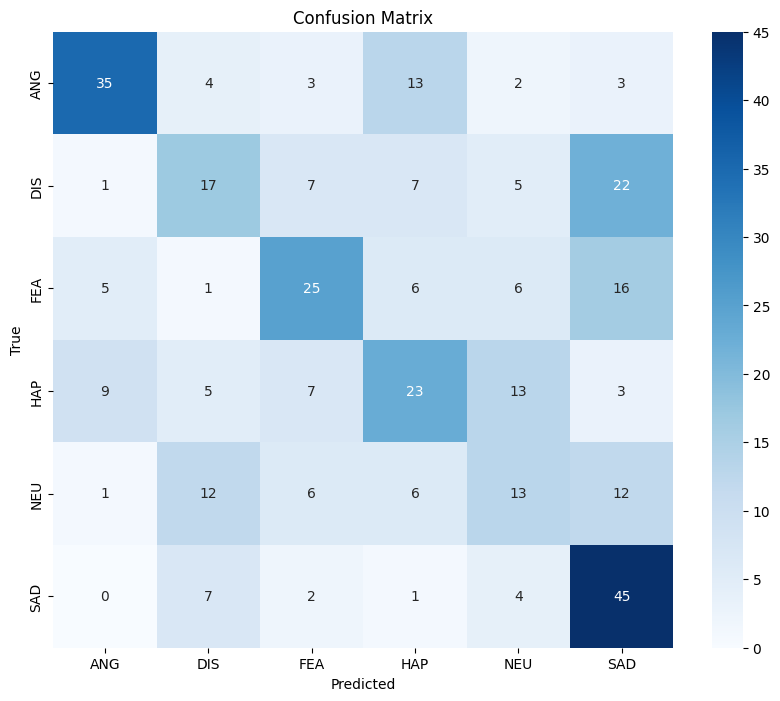

In [ ]:
# Validate the model
validation_results = validate_model(mlp, X_test, y_test, label_encoder)



Verifying model loading...
Error loading model: [Errno 2] No such file or directory: 'mlp_emotion_model.pkl'

Generating waveform visualizations for each emotion...

Testing prediction on sample file: 1010_ITH_FEA_XX.wav
True emotion: FEA
Predicted emotion: ANG
Prediction probabilities:
  ANG: 0.7585
  FEA: 0.1365
  HAP: 0.0858
  DIS: 0.0147
  NEU: 0.0042
  SAD: 0.0004


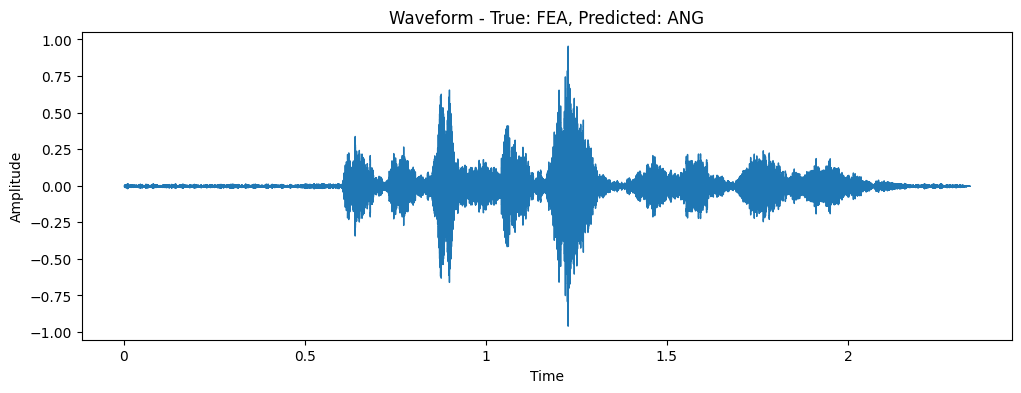

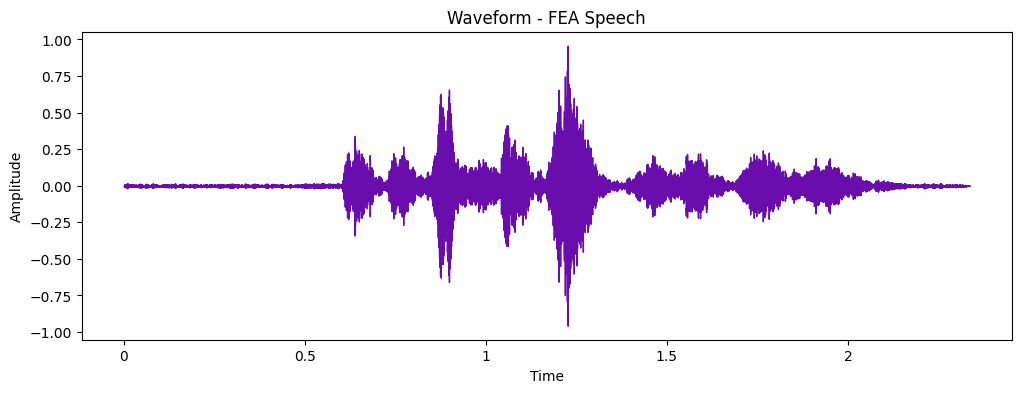

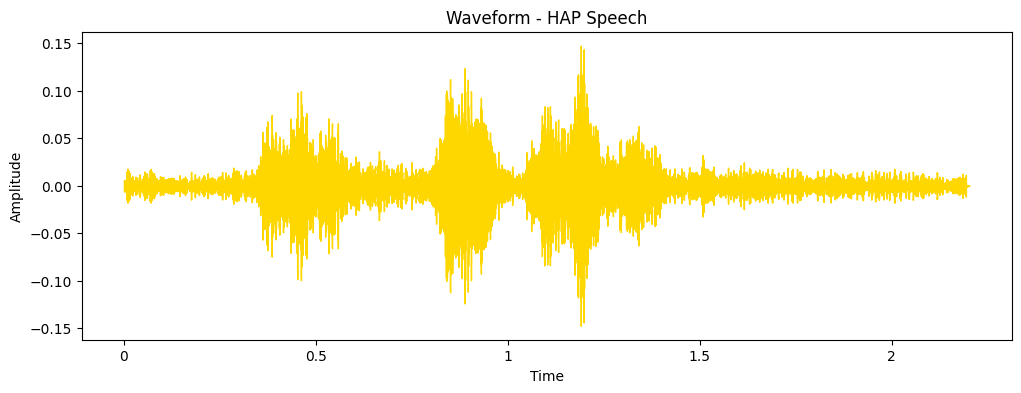

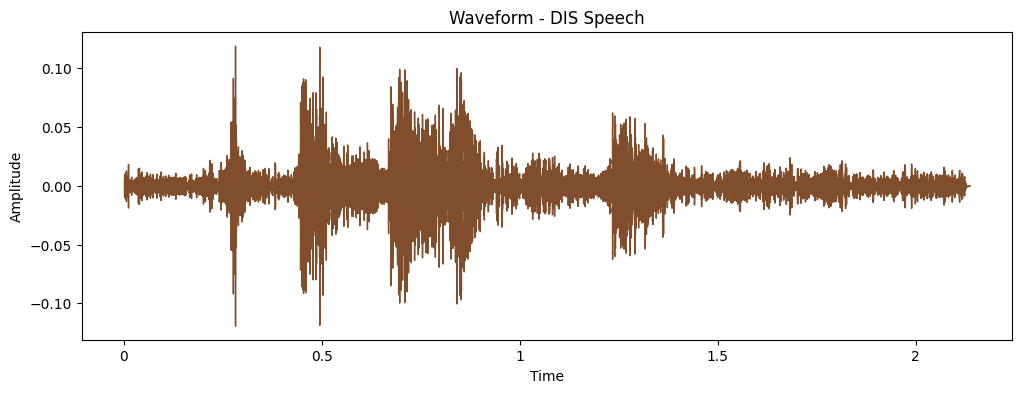

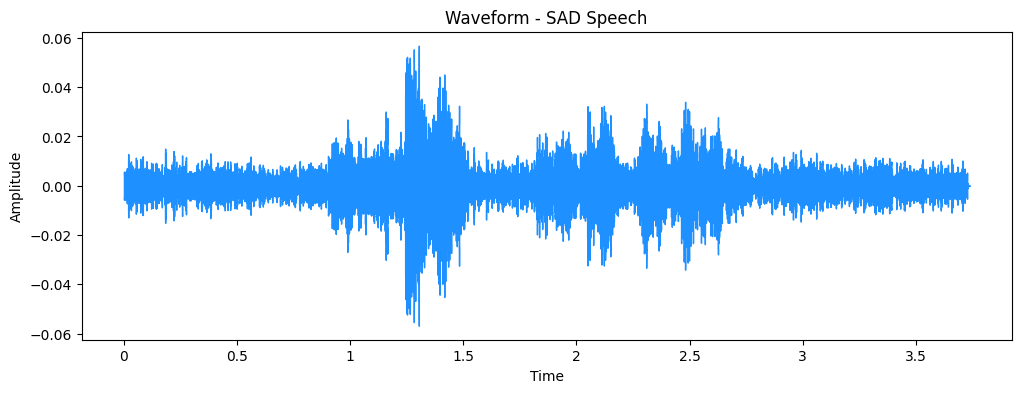

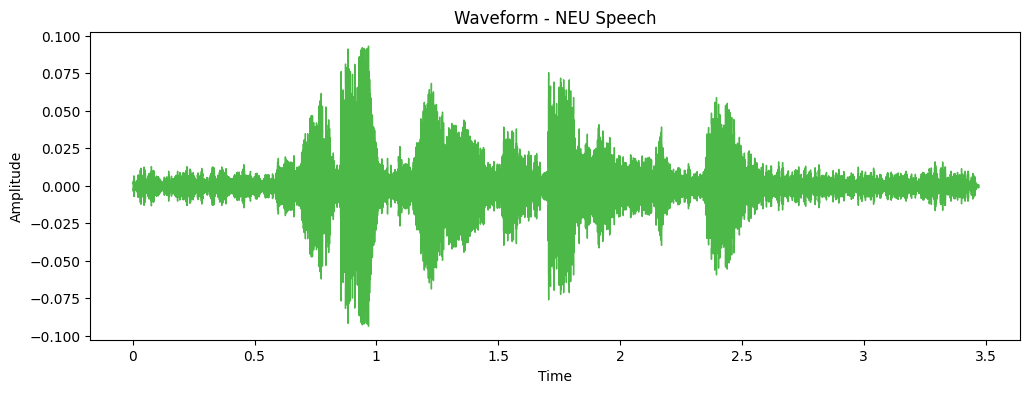

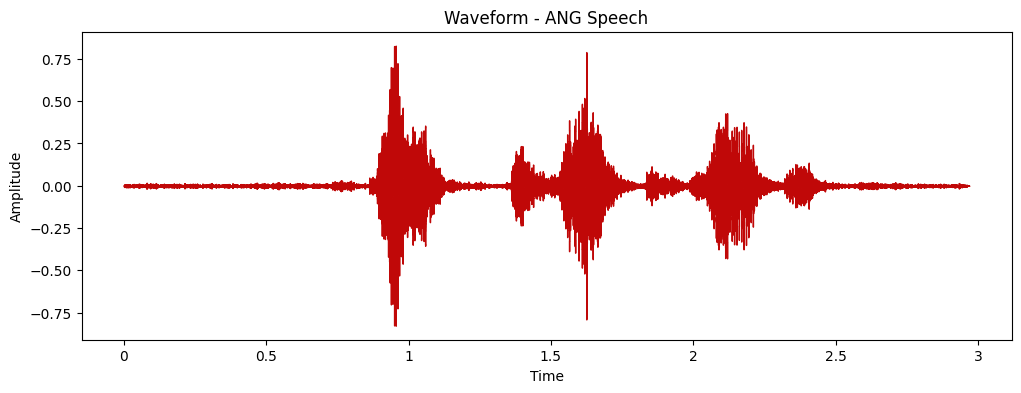

In [ ]:
# Load the model to verify it was saved correctly
print("\nVerifying model loading...")
try:
    loaded_model = joblib.load("mlp_emotion_model.pkl")
    loaded_scaler = joblib.load("scaler.pkl")
    loaded_encoder = joblib.load("label_encoder.pkl")

    # Check if the loaded model performs the same
    loaded_accuracy = loaded_model.score(X_test, y_test)
    print(f"Loaded model accuracy: {loaded_accuracy * 100:.2f}%")

    if abs(loaded_accuracy - validation_results['accuracy']) < 1e-5:
        print("Model loaded successfully and performs identically.")
    else:
        print("Warning: Loaded model performance differs from original model.")

except Exception as e:
    print(f"Error loading model: {e}")

# Visualization for All Emotions
colors = {'ANG': '#C00808', 'DIS': '#804E2D', 'FEA': '#6A0DAD', 'HAP': '#FFD700', 'NEU': '#4CB847', 'SAD': '#1E90FF'}

print("\nGenerating waveform visualizations for each emotion...")
for emotion in label_set:
    sample_files = audio_df[audio_df['Label'] == emotion]['Filepath']
    if not sample_files.empty:
        sample_file = sample_files.iloc[0]

        # Test prediction on this sample
        if emotion == list(label_set)[0]:  # Only do detailed prediction on first emotion to avoid clutter
            test_prediction(mlp, scaler, label_encoder, sample_file, wav_data, sr_dict)

        sample_array = wav_data.get(sample_file)
        sr = sr_dict.get(sample_file)

        if sample_array is not None and sr is not None:
            plt.figure(figsize=(12, 4))
            librosa.display.waveshow(sample_array, sr=sr, color=colors[emotion])
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
            plt.title(f'Waveform - {emotion} Speech')
            plt.show()


In [ ]:
def extract_enhanced_features(file):
    try:
        y_data, sr = librosa.load(file, sr=None, mono=True)
        if len(y_data) == 0:
            return None, None, None

        # Basic features
        zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y_data).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y_data, sr=sr).T, axis=0)
        mfcc = np.mean(librosa.feature.mfcc(y=y_data, sr=sr, n_mfcc=40).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=y_data, sr=sr).T, axis=0)

        # Additional features
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y_data, sr=sr).T, axis=0)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y_data, sr=sr).T, axis=0)
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y_data, sr=sr).T, axis=0)
        spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y_data).T, axis=0)

        # Pitch features
        f0, voiced_flag, voiced_probs = librosa.pyin(y_data, fmin=librosa.note_to_hz('C2'),
                                                   fmax=librosa.note_to_hz('C7'), sr=sr)
        f0 = f0[~np.isnan(f0)]  # Remove NaN values
        if len(f0) > 0:
            pitch_mean = np.mean(f0)
            pitch_std = np.std(f0)
        else:
            pitch_mean = 0
            pitch_std = 0

        # Energy features
        rms = np.mean(librosa.feature.rms(y=y_data).T, axis=0)

        # Stack all features
        features = np.hstack([
            zero_crossing, chroma, mfcc, mel,
            spectral_contrast, spectral_rolloff, spectral_bandwidth, spectral_flatness,
            np.array([pitch_mean, pitch_std]), rms
        ])

        return features, y_data, sr
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return None, None, None

In [ ]:
def train_enhanced_model(X_train, y_train, X_test, y_test):
    # Grid search for optimal hyperparameters
    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'hidden_layer_sizes': [(512, 256, 128), (256, 256, 128, 64)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01],
        'activation': ['relu', 'tanh']
    }

    mlp = MLPClassifier(
        solver='adam',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )

    grid_search = GridSearchCV(
        estimator=mlp,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    # Evaluate Model
    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)

    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

    return best_model

In [ ]:
# Train the model
mlp = train_model(X_train, y_train, X_test, y_test)

In [ ]:
# Save Model and Scaler
print("\nSaving model and preprocessing components...")
import joblib # Importing the joblib module
joblib.dump(mlp, "mlp_emotion_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
print("Model and components saved successfully.")


Saving model and preprocessing components...
Model and components saved successfully.


In [ ]:
# Load the model to verify it was saved correctly
print("\nVerifying model loading...")
try:
    loaded_model = joblib.load("mlp_emotion_model.pkl")
    loaded_scaler = joblib.load("scaler.pkl")
    loaded_encoder = joblib.load("label_encoder.pkl")

    # Check if the loaded model performs the same
    loaded_accuracy = loaded_model.score(X_test, y_test)
    print(f"Loaded model accuracy: {loaded_accuracy * 100:.2f}%")

    if abs(loaded_accuracy - validation_results['accuracy']) < 1e-5:
        print("Model loaded successfully and performs identically.")
    else:
        print("Warning: Loaded model performance differs from original model.")

except Exception as e:
    print(f"Error loading model: {e}")
